## Method comparison (RNN, MLP, IterativeGo, OneGo)## 
## FinalMetaData ##

In [1]:
import numpy as np
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.axes import Axes 
import math
import time
#from tensorflow import keras, set_random_seed
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
%matplotlib inline
#np.random.seed(42)
#set_random_seed(42)

## Reading the previous analysis results and making plots ## 
## Metric Files ##

In [15]:
## Metric frames ##
## OneGo ##
Path="/Users/mohammadmehdiezzatabadipour/Anadarko/"
## MetricFrame_IterativeGoMLP_test_ID4230133468_stage6_5Real_s10_t120.csv
nameIterGoMLP="IterativeGoMLP_test_ID4230133468_stage"#+str(6)+"_5Real_s10_t120.csv"
#nameGoMLP="OneGoMLP_test_ID4230133468_stage"#+str(6)+"_5Real_s10_t120.csv"
#nameGoRNN="OneGoRNN_test_ID4230133468_stage"#+str(6)+"_5Real_s10_t120.csv"
suffix1="_5Real_s2_t120.csv"
suffix2="_5Real_s10_t120.csv"
S=[2,10]
Suffix=["_5Real_s"+str(s)+"_t120.csv" for s in S]
Stages=[i for i in range(1,37)]#10,20,30,60,120,180,240,300] ## Sampling Window 
Metric=[[pd.read_csv(Path+'MetaData/MetricFrame_'+nameIterGoMLP+str(stg)+Suffix[i]) for stg in Stages] for i in range(len(Suffix))]
TS=[[pd.read_csv(Path+'MetaData/Uncertainty-Forecast_'+nameIterGoMLP+str(stg)+Suffix[i]) for stg in Stages] for i in range(len(Suffix))]
#MetricFrames=[]
#IterGoMLPMetricFrames=[pd.read_csv(File) for File in IterGoMLPMetricFiles]

In [10]:
len(TS)

2

<Figure size 432x288 with 0 Axes>

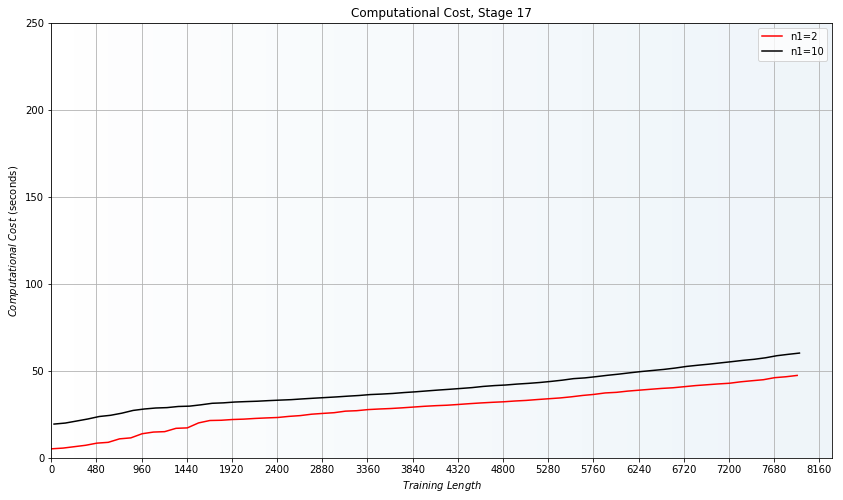

In [16]:
stage=17
S1=Metric[0][stage-1]
S2=Metric[1][stage-1]
#S2=GoRNNMetricFrames[stage-1]
#S3=IterGoMLPMetricFrames[stage-1]
plt.clf()
fig, ax = plt.subplots(figsize=(14,8),frameon=True)
plt.xlabel("$Training$ $Length$")
plt.ylabel("$Computational$ $Cost$ (seconds)")
plt.ylim(0,250)
plt.xlim(0,8300)
plt.title("Computational Cost, Stage "+str(stage))
ax.plot(S1.Section,S1.CalcTime,label="n1=2",color='r')
ax.plot(S2.Section,S2.CalcTime,label="n1=10",color='black')
#ax.plot(S3.Section,S3.CalcTime,label="IterGoMLP",color='r')
#    ax.plot(S1.Section,S1.CalcTime,label="Forecast Pressure Without Reg",color='b')

ax.legend()
x=[i for i in range(0,8500,480)]
for i in range(0,8500,120):
    plt.axvspan(i,i+120,alpha=0.1*math.sin(0.0001*i))

#for i in range(0,8000,480):
plt.xticks(x)
plt.grid(True)

#plt.savefig("Images/CompCost_OverFitting_Test.png")
plt.savefig(Path+"Images/CompCost_VarParams"+str(stage)+".png")
plt.show()

In [40]:
#nrmse=-1
#rmse=20
nrmse=-1
rmse=20

def NRMSE(Yo, Yp,L, meano):
    #(L,)=Yo.shape
    
    numerator=0
    denumerator=0
    for i in range(L):
        numerator=numerator+abs(Yp[i]-Yo[i])
        denumerator=denumerator+abs(Yo[i]-meano)
    return 1-numerator/denumerator
    

def RMSE(Yo, Yp,L):
    Sum=0
#    (L,)=Yo.shape        
    for i in range(L):
        Sum=Sum+(Yo[i]-Yp[i])**2
    return math.sqrt(Sum/L)

#nrmse=0
#rmse=100
def statNRMSE(Y):
    L=len(Y)
    N=0
    Sum=0
    for i in range(len(Y)):
        if nrmse<=Y[i]:
            N=N+1
            Sum=Sum+Y[i]
    Avg=Sum/N
    N=0
    Sum=0
    for i in range(len(Y)):
        if nrmse<=Y[i]:
            N=N+1
            Sum=Sum+(Y[i]-Avg)**2
    Sum=Sum/N
    
    return (Avg,math.sqrt(Sum))

def statRMSE(Y):
    L=len(Y)
    N=0
    Sum=0
    for i in range(len(Y)):
        if Y[i]<=rmse:
            N=N+1
            Sum=Sum+Y[i]
    Avg=Sum/N
    N=0
    Sum=0
    for i in range(len(Y)):
        if Y[i]<=rmse:
            N=N+1
            Sum=Sum+(Y[i]-Avg)**2
    Sum=Sum/N
    
    return (Avg,math.sqrt(Sum))

#sum(IterGoMLP_NRMSE)/len(IterGoMLP_NRMSE)
#sum(GoMLP_NRMSE)/len(IterGoMLP_NRMSE)

In [41]:
def VarMethod(stage, testSize):
    NRMSE_G=[[],[]]
    RMSE_G=[[],[]]
    
    frame=TS[0]
    (T,)=frame[stage-1].Forecast.shape#.mean()
    Forecast=frame[stage-1].Forecast
    Observation=frame[stage-1].Observation
    nSections=int(T/testSize)
    meano=Observation[:testSize].mean()
    for i in range(1,nSections):
        RMSE_G[0].append(RMSE(Observation[(i)*testSize:(i+1)*testSize].tolist(),Forecast[(i)*testSize:(i+1)*testSize].tolist(),testSize))
        NRMSE_G[0].append(NRMSE(Observation[(i)*testSize:(i+1)*testSize].tolist(),Forecast[(i)*testSize:(i+1)*testSize].tolist(),testSize,meano))
        meano=Observation[(i)*testSize:(i+1)*testSize].mean()

    frame=TS[1]
    (T,)=frame[stage-1].Forecast.shape
    Forecast=frame[stage-1].Forecast
    Observation=frame[stage-1].Observation
    nSections=int(T/testSize)
    meano=Observation[:testSize].mean()
    for i in range(1,nSections):
        RMSE_G[1].append(RMSE(Observation[(i)*testSize:(i+1)*testSize].tolist(),Forecast[(i)*testSize:(i+1)*testSize].tolist(),testSize))
        NRMSE_G[1].append(NRMSE(Observation[(i)*testSize:(i+1)*testSize].tolist(),Forecast[(i)*testSize:(i+1)*testSize].tolist(),testSize,meano))
        meano=Observation[(i)*testSize:(i+1)*testSize].mean()
        
        
    return [(statRMSE(RMSE_G[0]),statNRMSE(NRMSE_G[0])),(statRMSE(RMSE_G[1]),statNRMSE(NRMSE_G[1]))]

In [42]:
testSize=120
RMSE1=[i for i in range(len(Stages))]
NRMSE1=[i for i in range(len(Stages))]
RMSE2=[i for i in range(len(Stages))]
NRMSE2=[i for i in range(len(Stages))]

RMSE_err1=[i for i in range(len(Stages))]
NRMSE_err1=[i for i in range(len(Stages))]
RMSE_err2=[i for i in range(len(Stages))]
NRMSE_err2=[i for i in range(len(Stages))]

for i in range(len(Stages)):
    stage=Stages[i]
    [(x1,y1),(x2,y2)]=VarMethod(stage,testSize)
#    print([(x1,y1),(x2,y2),(x3,y3)])
    (x11,x12)=x1
    (y11,y12)=y1    
    (x21,x22)=x2
    (y21,y22)=y2    
    
    RMSE1[i]=x11
    NRMSE1[i]=y11
    
    RMSE2[i]=x21
    NRMSE2[i]=y22

    


<Figure size 432x288 with 0 Axes>

<Figure size 1008x576 with 0 Axes>

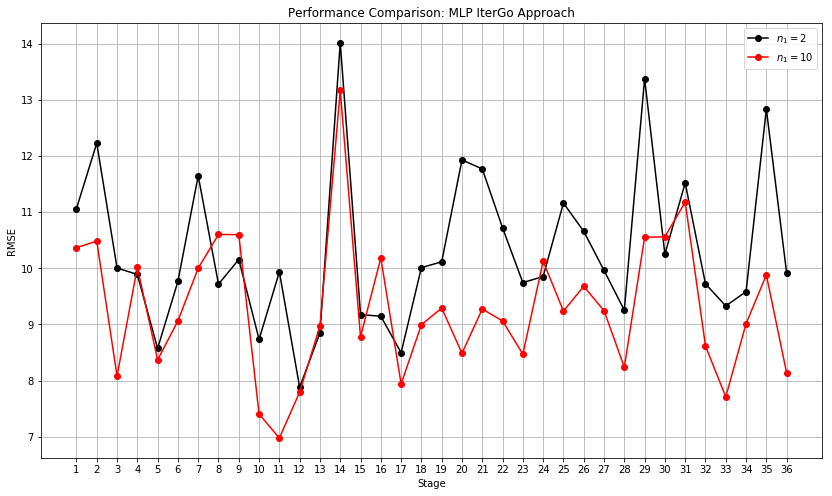

NRMSE


<Figure size 432x288 with 0 Axes>

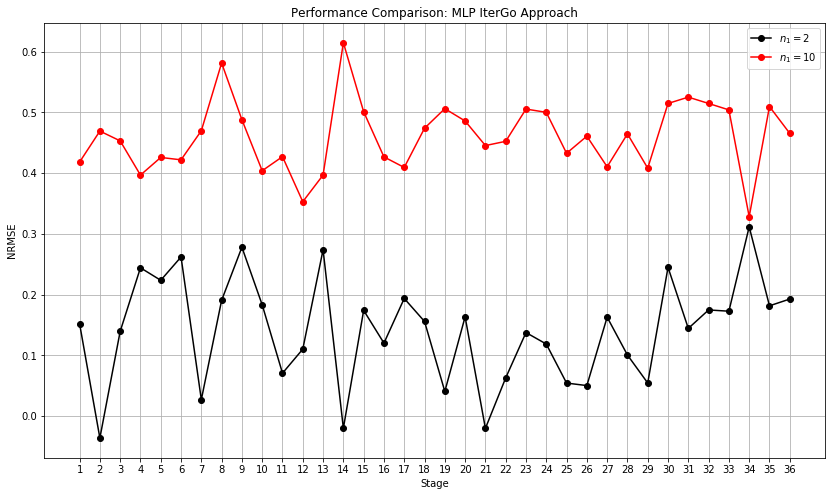

In [43]:
plt.clf()
fig, ax = plt.subplots(figsize=(14,8),frameon=True)

#NRMSE=GoMLP_NRMSE
#nrmseErr=[]
#Windows=[]
plt.clf()
fig, ax = plt.subplots(figsize=(14,8),frameon=True)
ax.set_title('Performance Comparison: MLP IterGo Approach')
ax.set_xlabel('Stage')    
ax.set_ylabel('RMSE')    
#ax.errorbar(Stages,GoRNN_RMSE,yerr=GoRNN_RMSE_err,fmt='-o',color='black',label="OneGo-RNN")
#ax.errorbar(Stages,GoMLP_RMSE,yerr=GoMLP_RMSE_err,fmt='-o',color='r',label="OneGo-MLP")
#ax.errorbar(Stages,IterGoMLP_RMSE,yerr=IterGoMLP_RMSE_err,fmt='-o',color='blue',label="IterativeGo-MLP")
ax.plot(Stages,RMSE1,'-o',color='black',label="$n_1=2$")
ax.plot(Stages,RMSE2,'-o',color='r',label="$n_1=10$")
#ax.plot(Stages,IterGoMLP_RMSE,'-o',color='blue',label="IterativeGo-MLP")

ax.legend()
plt.xticks(Stages)
plt.grid(True)

plt.savefig(Path+"Images/RMSE_VarParam.png")
plt.show()

#plt.savefig("Images/RMSE_Window_LC.png")
#plt.pl
#plt.ylim(0,50)

print('NRMSE')
plt.clf()
fig, ax = plt.subplots(figsize=(14,8),frameon=True)
ax.set_title('Performance Comparison: MLP IterGo Approach')
ax.set_xlabel('Stage')    
ax.set_ylabel('NRMSE')    

#ax.errorbar(Stages,GoRNN_NRMSE,yerr=GoRNN_NRMSE_err,fmt='-o',color='black',label="OneGo-RNN")
#ax.errorbar(Stages,GoMLP_NRMSE,yerr=GoMLP_NRMSE_err,fmt='-o',color='r',label="OneGo-MLP")
#ax.errorbar(Stages,IterGoMLP_NRMSE,yerr=IterGoMLP_NRMSE_err,fmt='-o',color='b',label="IterativeGo-MLP")
ax.plot(Stages,NRMSE1,'-o',color='black',label="$n_1=2$")
ax.plot(Stages,NRMSE2,'-o',color='r',label="$n_1=10$")
#ax.plot(Stages,NRMSE,'-o',color='blue',label="IterativeGo-MLP")

ax.legend()

plt.xticks(Stages)
plt.grid(True)
#plt.ylim(0,1)
plt.savefig(Path+"Images/NRMSE_VarParam.png")
#plt.pl
plt.show()